<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><font size = "7"> Apprentice Chef - Analysis Report </font>

Submitted by - Aveka Patawari<br>
Date - 01/28/2021<br>

<b>Hult International Business School</b><br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
 
<br>


<font size = "6"><b> Introduction</b></font>

<u>The objectives of this report are:</u>
1. Predict revenue generated over the first year of each customer’s life cycle through Revenue (Regression) model.
2. Predict which customers will subscribe to "Halfway There" cross-selling promotion using Classification model.

In [1]:
# importing important packages and libraries:

# importing libraries
import random as rand                               # random number generated
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression  # logistic regression
import sklearn.linear_model

from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler

# CART model packages
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO                             # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects

from sklearn.model_selection import RandomizedSearchCV     # hyperparameter tuning
from sklearn.metrics import make_scorer                    # customizable scorer

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)



# specifying file name
file = './datasets/Apprentice_Chef_Dataset.xlsx'

# reading the file into Python
chef_df = pd.read_excel(file)


# Revenue Model


## FEATURE ENGINEERING
 

In [2]:
# Imputing Missing values - 'FAMILY_NAME'

# instantiating an imputation value
fill = 'Unknown'

# imputing 'FAMILY_NAME'
chef_df['FAMILY_NAME'] = chef_df['FAMILY_NAME'].fillna(fill)


In [3]:
# FEATURE ENGINEERING

# ADDITIONAL CALCULATIONS
chef_df['TOTAL_CANCELLATIONS'] = chef_df['CANCELLATIONS_BEFORE_NOON'] + chef_df['CANCELLATIONS_AFTER_NOON']
chef_df['TOTAL_ENGAGEMENT'] = chef_df['MOBILE_LOGINS'] + chef_df['PC_LOGINS']
chef_df['OVERALL_UNIQUE'] = chef_df['UNIQUE_MEALS_PURCH'] / chef_df['TOTAL_MEALS_ORDERED']
chef_df['NO_CANCELLATIONS'] = chef_df['TOTAL_MEALS_ORDERED'] - chef_df['CANCELLATIONS_BEFORE_NOON']
chef_df['TOTAL_LATE'] = chef_df['LATE_DELIVERIES'] / chef_df['TOTAL_MEALS_ORDERED']
chef_df['TOTAL_EARLY'] = chef_df['EARLY_DELIVERIES'] / chef_df['TOTAL_MEALS_ORDERED']
chef_df['ORDER_PER_CATEGORY'] = chef_df['LARGEST_ORDER_SIZE'] / chef_df['PRODUCT_CATEGORIES_VIEWED']
chef_df['ORDER_PER_CONTACT'] = chef_df['CONTACTS_W_CUSTOMER_SERVICE'] / chef_df['LARGEST_ORDER_SIZE']


# dummy variable
chef_df['HAS_CANCELLED']   = 0
chef_df['HAS_ATTENDED_MASTERCLASS']   = 0
chef_df['SUBCSCRIBED_WEEKLY_PLAN']   = 0
chef_df['VIEWED_PHOTOS']   = 0
chef_df['HIGH_ENGAGEMENT']   = 0

for index, value in chef_df.iterrows():
    
    # TOTAL_CANCELLATIONS
    if chef_df.loc[index, 'TOTAL_CANCELLATIONS'] > 0:
        chef_df.loc[index, 'HAS_CANCELLED'] = 1
            
    # MASTER_CLASSES_ATTENDED
    if chef_df.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chef_df.loc[index, 'HAS_ATTENDED_MASTERCLASS'] = 1
        
    # WEEKLY_PLAN
    if chef_df.loc[index, 'WEEKLY_PLAN'] > 0:
        chef_df.loc[index, 'SUBCSCRIBED_WEEKLY_PLAN'] = 1
        
    # TOTAL_PHOTOS_VIEWED
    if chef_df.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        chef_df.loc[index, 'VIEWED_PHOTOS'] = 1
        
    # TOTAL_ENGAGEMENT
    if chef_df.loc[index, 'TOTAL_ENGAGEMENT'] > 0 and chef_df.loc[index, 'AVG_TIME_PER_SITE_VISIT'] > 94:
        chef_df.loc[index, 'HIGH_ENGAGEMENT'] = 1

In [4]:
# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_df.iterrows():
    
    # splitting email domain at '@'
    split_email = chef_df.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)


In [5]:
# email domain types
professional_email = ['@mmm.com', '@amex.com', '@boeing.com', '@apple.com',
                      '@caterpillar.com','@chevron.com' ,'@cisco.com' , '@cocacola.com',
                      '@disney.com' , '@dupont.com' , '@dupont.com' , '@exxon.com',
                      '@ge.org', '@homedepot.com' , '@goldmansacs.com', '@ibm.com',
                      '@intel.com', '@jnj.com', '@jpmorgan.com' , '@mcdonalds.com', 
                      '@merck.com' , '@microsoft.com', '@nike.com', '@pfizer.com', 
                      '@pg.com' , '@travelers.com', '@unitedtech.com' , 
                      '@unitedhealth.com' , '@verizon.com', '@visa.com', '@walmart.com']

personal_email  = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email = ['@me.com','@aol.com','@hotmail.com','@live.com','@msn.com','@passport.com']

# placeholder list
placeholder_lst = []


# looping to group observations by domain type
for domain in email_df[1]:
    
    if '@' + domain in professional_email:
        placeholder_lst.append('Professional')
        

    elif '@' + domain in personal_email:
        placeholder_lst.append('Personal')

    elif '@' + domain in junk_email:
        placeholder_lst.append('Junk')
        
    else:
            print('Unknown')


# concatenating with original DataFrame
chef_df['DOMAIN_GRP'] = pd.Series(placeholder_lst)


# checking results
chef_df['DOMAIN_GRP'].value_counts()

Personal        861
Professional    696
Junk            389
Name: DOMAIN_GRP, dtype: int64

## One-Hot Encoding:

In [6]:
# SPLITTING EMAIL INTO professional, Personal, Junk Categories

# one hot encoding
one_hot_domain       = pd.get_dummies(chef_df['DOMAIN_GRP'])
one_hot_median_meal  = pd.get_dummies(chef_df['MEDIAN_MEAL_RATING'])

# dropping categorical variables after they've been encoded
chef_df = chef_df.drop('DOMAIN_GRP', axis = 1)
one_hot_median_meal.columns = ['rating_1' , 'rating_2', 'rating_3', 'rating_4', 'rating_5']

# joining codings together
chef_df = chef_df.join(one_hot_domain)
chef_df = chef_df.join(one_hot_median_meal)

In [7]:
# log transforming variables and saving it to the dataset
chef_df['LOG_REVENUE'] = np.log10(chef_df['REVENUE'])
chef_df['LOG_AVG_PREP_VID_TIME'] = np.log10(chef_df['AVG_PREP_VID_TIME'])
chef_df['LOG_TOTAL_MEALS_ORDERED'] = np.log10(chef_df['TOTAL_MEALS_ORDERED'])



In [8]:
# preparing explanatory variable data
chef_df_data   = chef_df.drop(['REVENUE',
                               'LOG_REVENUE',
                               'NAME',
                               'EMAIL', 
                               'FIRST_NAME',
                               'FAMILY_NAME'], axis = 1)


# preparing response variable data
chef_df_target = chef_df.loc[ : , 'REVENUE']
log_chef_target = chef_df.loc[ : , 'LOG_REVENUE'] # ready for use later

# preparing training and testing sets (all letters are lowercase)
x_train, x_test, y_train, y_test = train_test_split(
            chef_df_data,
            chef_df_target,
            test_size = 0.25,
            random_state = 219)


# checking the shapes of the datasets
print(f"""
Training Data                    
-------------                     
X-side: {x_train.shape}                
y-side: {y_train.shape}                  

Testing Data                     
-------------                     
X-side: {x_test.shape}                
y-side: {y_test.shape}
""")



Training Data                     Testing Data
-------------                     ------------
X-side: (1459, 46)           X-side: (487, 46)
y-side: (1459,)           y-side: (487,)




In [9]:
# merging X_train and y_train so that they can be used in statsmodels
chef_df_train = pd.concat([x_train, y_train], axis = 1)

In [10]:
# declaring set of x-variables
x_variables = ['CROSS_SELL_SUCCESS', 'LOG_TOTAL_MEALS_ORDERED', 'CONTACTS_W_CUSTOMER_SERVICE',
               'PRODUCT_CATEGORIES_VIEWED', 'LATE_DELIVERIES', 'LOG_AVG_PREP_VID_TIME',
               'LARGEST_ORDER_SIZE', 'MASTER_CLASSES_ATTENDED', 'MEDIAN_MEAL_RATING',
               'OVERALL_UNIQUE', 'TOTAL_LATE', 'HIGH_ENGAGEMENT',
               'rating_4', 'ORDER_PER_CATEGORY']

In [11]:
# applying model in scikit-learn

# Preparing a DataFrame based the the analysis above
ols_data   = chef_df.loc[ : , x_variables]


# Preparing the target variable
chef_df_target = chef_df.loc[ : , 'REVENUE']


###############################################
## setting up more than one train-test split ##
###############################################
# FULL X-dataset (normal Y)
x_train_FULL, x_test_FULL, y_train_FULL, y_test_FULL = train_test_split(
            chef_df_data,     # x-variables
            chef_df_target,   # y-variable
            test_size = 0.25,
            random_state = 219)


# OLS p-value x-dataset (normal Y)
x_train_OLS, x_test_OLS, y_train_OLS, y_test_OLS = train_test_split(
            ols_data,         # x-variables
            chef_df_target,   # y-variable
            test_size = 0.25,
            random_state = 219)

In [12]:
# ARD MODEL_FINAL:

# INSTANTIATING a model object
ard_model = sklearn.linear_model.ARDRegression(normalize  = False)


# FITTING the training data
ard_fit = ard_model.fit(x_train_FULL, y_train_FULL)


# PREDICTING on new data
ard_pred = ard_fit.predict(x_test_FULL)


print('Training Score:', ard_model.score(x_train_FULL, y_train_FULL).round(4))
print('Testing Score :',  ard_model.score(x_test_FULL, y_test_FULL).round(4))


# saving scoring data for future use
ard_train_score = ard_model.score(x_train_FULL, y_train_FULL).round(4)
ard_test_score  = ard_model.score(x_test_FULL, y_test_FULL).round(4)


# displaying and saving the gap between training and testing
print('ARD Train-Test Gap :', abs(ard_train_score - ard_test_score).round(4))
ard_test_gap = abs(ard_train_score - ard_test_score).round(4)

Training Score: 0.6722
Testing Score : 0.717
ARD Train-Test Gap : 0.0448


<font size = "4"><b>ARD model analysis :</b></font><br>
The analysis is done using the ARD regression model with Revenue as our Response variable. The model has a Testing(prediction) score of 0.717.

In [13]:
# zipping each feature name to its coefficient
ard_model_values = zip(chef_df_data.columns, ard_fit.coef_.round(decimals = 5))


# setting up a placeholder list to store model features
ard_model_lst = [('intercept', ard_fit.intercept_.round(decimals = 2))]

# printing out each feature-coefficient pair one by one
for val in ard_model_values:
    ard_model_lst.append(val)

ard_df = pd.DataFrame(ard_model_lst,columns=['coeff','intercept'])
print(ard_df.iloc[[5, 10, 18, 20], :])

                        coeff  intercept
5   PRODUCT_CATEGORIES_VIEWED   23.76137
10     TASTES_AND_PREFERENCES   16.72529
18          AVG_PREP_VID_TIME    8.68627
20    MASTER_CLASSES_ATTENDED  175.40677


For every one unit change in Master classes attended, we expect an increase in Revenue of approximately $175.40, all else equal.

<b><font size = '3'>Actionable insights</font></b>
<br> 1 .  As analyzed above, master classes have a positive impact on the revenue and so the company should increase the frequency of master class from once every quarter to once per month to increase customer engagement and retention.</br>
<br> 2 .  Watching prep videos also showed a positive relation with revenue. The company can focus on releasing more such videos to attract new customers.</br>


# <i>"Halfway There"</i>  cross-selling promotion

In [14]:
#feature engineering:
chef_df['name_length'] = chef_df.loc[:,'NAME'].str.len()
chef_df['AVG_SPENDING'] = chef_df['REVENUE'] / chef_df['TOTAL_MEALS_ORDERED']
chef_df['OUT_AVG_PREP_VID_TIME'] = 0

for index, value in chef_df.iterrows():


    if chef_df.loc[index, 'AVG_PREP_VID_TIME'] > 270:
       chef_df.loc[index, 'OUT_AVG_PREP_VID_TIME'] = 1

In [15]:
# declaring explanatory variables
chef_df_data = chef_df.drop(['CROSS_SELL_SUCCESS','NAME','FIRST_NAME','EMAIL','FAMILY_NAME'], axis = 1)


# declaring response variable
chef_df_target = chef_df.loc[ : , 'CROSS_SELL_SUCCESS']

In [16]:
# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['TOTAL_MEALS_ORDERED','UNIQUE_MEALS_PURCH','CONTACTS_W_CUSTOMER_SERVICE',
                   'PRODUCT_CATEGORIES_VIEWED','AVG_TIME_PER_SITE_VISIT','MOBILE_NUMBER',
                   'CANCELLATIONS_BEFORE_NOON','CANCELLATIONS_AFTER_NOON','TASTES_AND_PREFERENCES',
                   'PC_LOGINS','MOBILE_LOGINS','WEEKLY_PLAN','EARLY_DELIVERIES','LATE_DELIVERIES',
                   'PACKAGE_LOCKER','REFRIGERATED_LOCKER','AVG_PREP_VID_TIME','LARGEST_ORDER_SIZE',
                   'MASTER_CLASSES_ATTENDED','MEDIAN_MEAL_RATING','AVG_CLICKS_PER_VISIT',
                   'TOTAL_PHOTOS_VIEWED','name_length','Personal','Professional',
                   'AVG_SPENDING'], 
 
    
    
    # significant variables only (set 1)
 'logit_sig'    : ['TOTAL_MEALS_ORDERED','CONTACTS_W_CUSTOMER_SERVICE','MOBILE_NUMBER','CANCELLATIONS_BEFORE_NOON',
                   'TASTES_AND_PREFERENCES','PC_LOGINS','EARLY_DELIVERIES', 'REFRIGERATED_LOCKER',
                   'MEDIAN_MEAL_RATING','name_length','Personal','Professional', 'AVG_SPENDING',
                   'OUT_AVG_PREP_VID_TIME']
    

 

}

In [17]:
########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

In [18]:
# train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            chef_df_data,
            chef_df_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = chef_df_target)


# merging training data for statsmodels
chef_df_train = pd.concat([X_train, y_train], axis = 1)

In [19]:
# INSTANTIATING a classification tree object
tuned_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=11,
                       random_state=219)
        

# using fit since not directly imputing estimator values
# FITTING the training data
tuned_tree_fit  = tuned_tree.fit(chef_df_data, chef_df_target)


# PREDICTING on new data
tuned_tree_pred = tuned_tree_fit.predict(X_test)


# SCORING the model
print('Training ACCURACY:', tuned_tree_fit.score(X_train, y_train).round(4))
print('Testing  ACCURACY:', tuned_tree_fit.score(X_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = tuned_tree_pred).round(4))


# saving scoring data for future use
tuned_tree_train_score = tuned_tree_fit.score(X_train, y_train).round(4) # accuracy
tuned_tree_test_score  = tuned_tree_fit.score(X_test, y_test).round(4)   # accuracy


# saving auc score
tuned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = tuned_tree_pred).round(4) # auc

Training ACCURACY: 0.7656
Testing  ACCURACY: 0.77
AUC Score        : 0.7122


<font size = "4"><b>Classification Analysis : Decision Tree</b></font><br>
The analysis is done using Tuned tree the with Cross-sell-success as our Response variable. The model above has AUC score of 0.712.

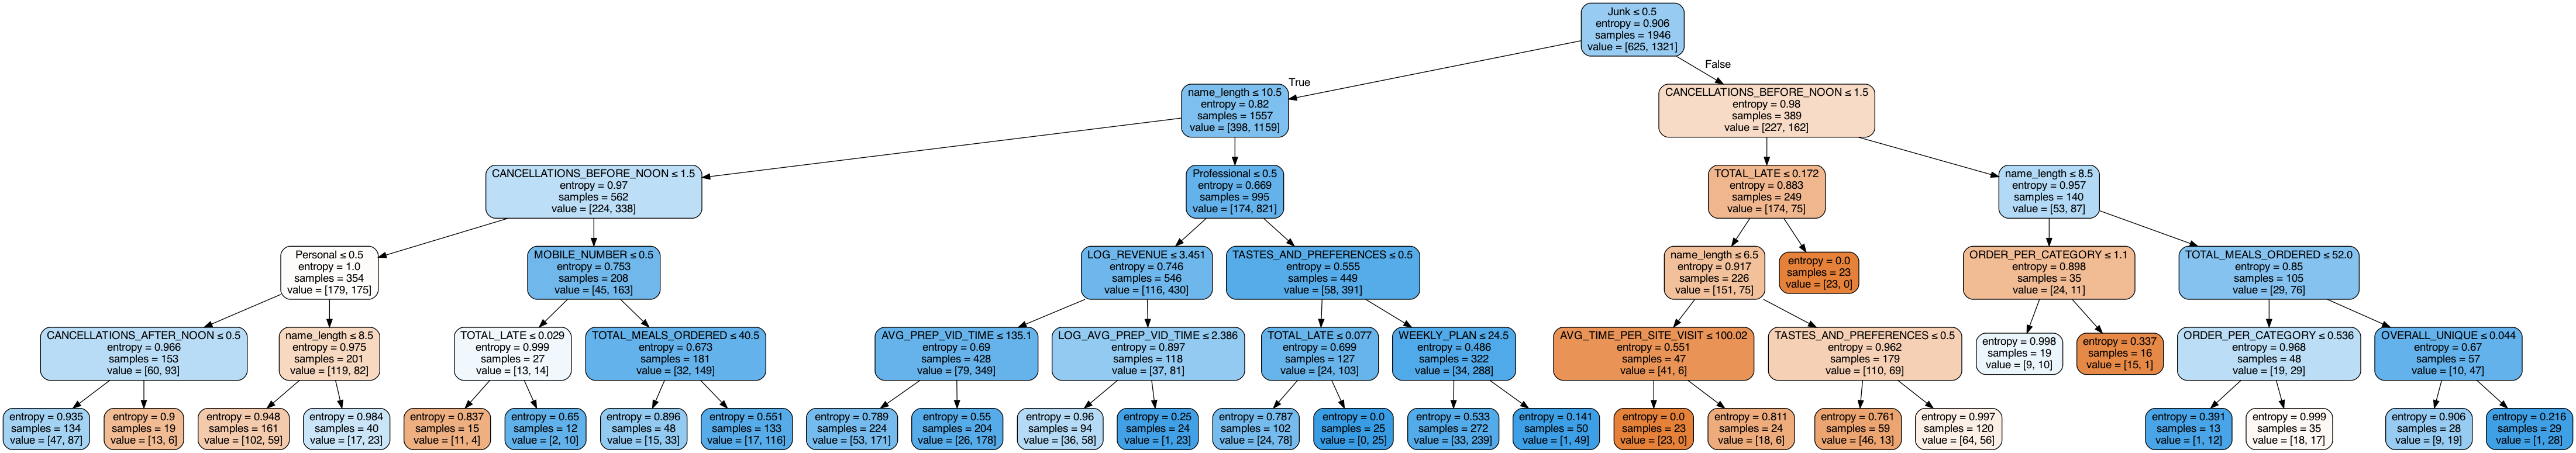

In [20]:
# displaying the tree
display_tree(tree = tuned_tree,
             feature_df = chef_df_data,
             height = 1500,
             width  = 1500)

/Users/aveka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


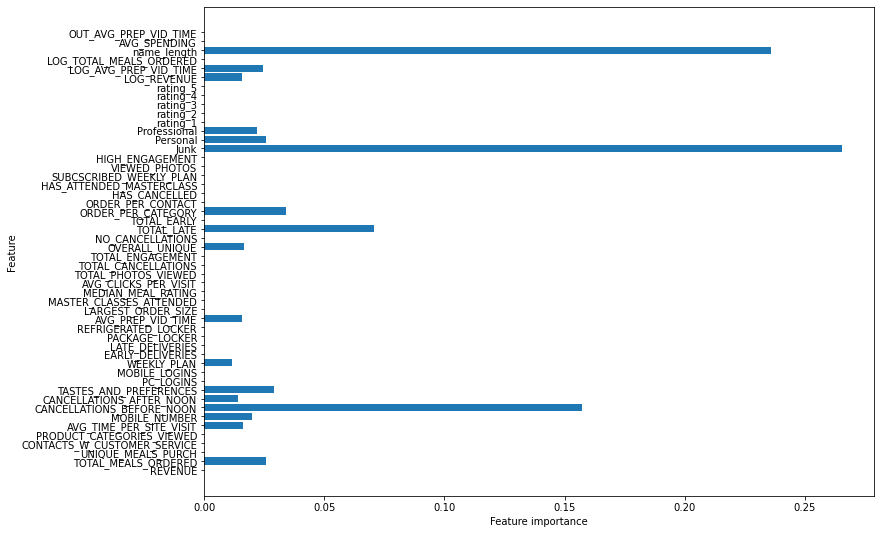

In [21]:
# plotting feature importance
plot_feature_importances(tuned_tree_fit,
                         train = X_train,
                         export = False)

Looking at the decision tree and feature importance table, we can see that junk emails and cancellations made before noon have highest impact on the success of "Halfway There" cross-sell promotion.

<b><font size = '3'>Actionable insights and conclusion:</font></b>
<br> 1 .  Efforts should be made to have a more proper segregation of emails as important emails could be labeled as junk. This can be done by restricting customers to register using limited domain names. </br>
<br> 2 .  Since customers receive a full refund for cancellations made before noon this could increase the number of cancellations. The company and introduce partial refund policy or fee.</br>
